# Import libraries

In [1]:
# General libraries
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm
import warnings
import yaml

# TiRex
from tirex import load_model, ForecastModel, TiRexZero
from tirex_util import load_tirex_from_checkpoint, plot_forecast, create_incrementing_folder

warnings.filterwarnings("ignore")


In [2]:
def calculate_metrics(df, folder_path):
    """Compute metrics (MAPE, RMSE), plot residuals and save results."""
    os.makedirs(folder_path, exist_ok=True)
    
    # Ensure proper typing
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])
    df["resid"] = df["obs"] - df["median_pred"]
    
    # Metrics
    mape_mean = np.mean(np.abs((df["obs"] - df["median_pred"]) / df["obs"])) * 100
    rmse_mean = np.sqrt(np.mean((df["obs"] - df["median_pred"])**2))
        
    # Plot residuals
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df, x="date", y="resid", color="steelblue", linewidth=1.5)
    plt.axhline(0, color="gray", linestyle="--", linewidth=1)
    plt.title(f"Residuals over Time\nMAPE: {mape_mean:.2f}%  |  RMSE: {rmse_mean:.0f} MW", fontsize=13)
    plt.xlabel("Date")
    plt.ylabel("Residual (Observed - Predicted)")
    plt.tight_layout()
    
    plt.savefig(os.path.join(folder_path, "residuals.png"), dpi=200)
    plt.close()

    plt.figure(figsize=(10, 5))
    plt.plot(df["date"], df["obs"], label="Observed", color="black", linewidth=1.2)
    plt.plot(df["date"], df["median_pred"], label="Predicted (Median)", color="royalblue", linewidth=1.2)
    plt.fill_between(df["date"], df["q10_pred"], df["q90_pred"], color="lightblue", alpha=0.4)
    plt.legend()
    plt.title("Observed vs Predicted Consumption")
    plt.xlabel("Date")
    plt.ylabel("Consumption [MW]")
    plt.tight_layout()
    plt.savefig(os.path.join(folder_path, "forecast_comparison.png"), dpi=200)
    plt.close()
    print('MAPE: {:.2f}%, RMSE: {:.2f} MW'.format(mape_mean, rmse_mean))
    return mape_mean, rmse_mean

def visualize_existing_results(config_files):
    """Display existing results and save residual plots next to sequence.csv."""
    for cfg in config_files:
        with open(cfg, "r") as file:
            config = yaml.safe_load(file)
        result_path = os.path.join("results_tirex", config["expe_name"], "sequence.csv")

        if not os.path.exists(result_path):
            print(f"No results for {config['expe_name']}")
            continue

        df = pd.read_csv(result_path)

        required_cols = ["date", "obs", "median_pred", "q10_pred", "q90_pred"]
        if df.empty or any(col not in df.columns for col in required_cols):
            print(f"Invalid file: {result_path}")
            continue

        # Display forecast
        plt.figure(figsize=(10, 5))
        plt.plot(df["date"], df["obs"], label="Observation", color="black")
        plt.plot(df["date"], df["median_pred"], label="Median forecast", color="blue")
        plt.fill_between(df["date"], df["q10_pred"], df["q90_pred"], color="lightblue", alpha=0.5)
        plt.legend()
        plt.title(f"TiRex ZS Forecast — {config['expe_name']}")
        plt.xlabel("Date")
        plt.ylabel("Consumption [MW]")
        plt.tight_layout()

        out_dir = os.path.dirname(result_path)
        plt.savefig(os.path.join(out_dir, "forecast_comparison.png"), dpi=200)
        plt.show()
        plt.close()

        # Save residuals plot in the same folder as sequence.csv
        try:
            d = df.copy()
            d["date"] = pd.to_datetime(d["date"])
            d["resid"] = d["obs"] - d["median_pred"]

            mask = d["obs"] != 0
            mape_mean = np.mean(np.abs((d.loc[mask, "obs"] - d.loc[mask, "median_pred"]) / d.loc[mask, "obs"])) * 100
            rmse_mean = np.sqrt(np.mean((d["obs"] - d["median_pred"]) ** 2))

            plt.figure(figsize=(10, 5))
            sns.lineplot(data=d, x="date", y="resid", color="steelblue", linewidth=1.5)
            plt.axhline(0, color="gray", linestyle="--", linewidth=1)
            plt.title(f"Residuals over Time — {config['expe_name']}\nMAPE: {mape_mean:.2f}%  |  RMSE: {rmse_mean:.0f} MW")
            plt.xlabel("Date")
            plt.ylabel("Residual (Observed - Predicted)")
            plt.tight_layout()

            out_dir = os.path.dirname(result_path)
            plt.savefig(os.path.join(out_dir, "residuals.png"), dpi=200)
            plt.close()
        except Exception as e:
            print(f"Could not save residual plot for {config['expe_name']}: {e}")

def run_experiment(config_path, CHECKPOINT_FILE, MODEL_ID):
    print(f"\nLoading config : {config_path}")
    with open(config_path, "r") as file:
        config = yaml.safe_load(file)

    # Chargement des données
    data = pd.read_csv(config["data_path"])
    data["Date_local"] = pd.to_datetime(data["Date_local"]).dt.tz_localize(None)

    begin_train = pd.to_datetime(config["begin_train"])
    begin_test = pd.to_datetime(config["begin_test"])
    end_test = pd.to_datetime(config["end_test"])
    horizon = config["horizon"]

    folder_path = create_incrementing_folder(f"results_tirex/{config['expe_name']}")
    print(f"Results saved in dans : {folder_path}")

    X = data[(data["Date_local"] >= begin_train) & (data["Date_local"] < end_test)].reset_index(drop=True)
    y_test = X[(X["Date_local"] >= begin_test) & (X["Date_local"] < end_test)]["Consommation"].values

    if os.path.isfile(CHECKPOINT_FILE):
        tirex_model = load_tirex_from_checkpoint(checkpoint_path=CHECKPOINT_FILE, model_id=MODEL_ID)
        print("Model loaded from checkpoint.")
    else:
        print("Could not find checkpoint: loading from Hugging Face.")
        tirex_model = load_model("NX-AI/TiRex")

    quantiles_full, mean_full = [], []
    hist = X[X["Date_local"] <= begin_test]["Consommation"].values
    fut = X[X["Date_local"] > begin_test]["Consommation"].values

    print(f"Lauching forecasts (horizon={horizon})...")
    for i in tqdm(range(0, len(y_test), horizon)):
        ctx = np.concatenate((hist, fut[0:i]))
        quantiles, mean = tirex_model.forecast(ctx, prediction_length=horizon)
        mean_full.append(mean)
        quantiles_full.append(quantiles[0])

    m = torch.cat(mean_full, dim=1)
    q = torch.cat(quantiles_full, dim=0)
    q10_pred = torch.tensor([t[0] for t in torch.unbind(q)])
    median_pred = torch.tensor([t[4] for t in torch.unbind(q)])
    q90_pred = torch.tensor([t[8] for t in torch.unbind(q)])
    y_test = torch.tensor(y_test)
    dates_test = X[(X["Date_local"] >= begin_test) & (X["Date_local"] < end_test)]["Date_local"]

    final = pd.DataFrame({
        "date": dates_test,
        "obs": y_test,
        "q10_pred": q10_pred,
        "q90_pred": q90_pred,
        "median_pred": median_pred
    })
    output_file = os.path.join(folder_path, "sequence.csv")
    final.to_csv(output_file, index=False)
    print(f"Results saved : {output_file}")
    return final

# Import data

In [3]:
train_weave   = pd.read_csv('data/weave/train_weave.csv')
train_rfrance = pd.read_csv('data/rfrance/train2.csv')
test_weave    = pd.read_csv('data/weave/test_weave.csv')
test_rfrance  = pd.read_csv('data/rfrance/test2.csv')

df_weave   = pd.concat([train_weave, test_weave], axis=0).reset_index(drop=True)
df_rfrance = pd.concat([train_rfrance, test_rfrance], axis=0).reset_index(drop=True)

In [4]:
# Export Weave by site 
os.makedirs('data/weave', exist_ok=True)
nb_ids = df_weave['id_unique'].nunique()
pad = max(3, len(str(nb_ids)))

weave_out = (
    df_weave[['date', 'id_unique', 'consumption']]
    .rename(columns={'date': 'Date_local', 'consumption': 'Consommation'})
    .assign(Date_local=lambda d: pd.to_datetime(d['Date_local']))
)

for i, (_, g) in enumerate(weave_out.groupby('id_unique', sort=False), start=1):
    g = g.sort_values('Date_local')
    g[['Date_local', 'id_unique', 'Consommation']].to_csv(
        f"data/weave/{i:0{pad}d}.csv", index=False
    )

uk = df_weave[['date','consumption']].groupby('date').sum().reset_index().sort_values('date')
uk.columns = ['Date_local','Consommation']
uk.to_csv('data/weave/uk.csv')

# Export RFrance by region
os.makedirs('data/rfrance', exist_ok=True)

rfr_out = (
    df_rfrance[['date', 'Region', 'load']]
    .rename(columns={'date': 'Date_local', 'load': 'Consommation'})
    .assign(Date_local=lambda d: pd.to_datetime(d['Date_local']))
)

for region, g in rfr_out.groupby('Region', sort=False):
    g = g.sort_values('Date_local')
    g[['Date_local', 'Region', 'Consommation']].to_csv(
        f"data/rfrance/{region[:5]}.csv", index=False
    )

france = df_rfrance[['date','load']].groupby('date').sum().reset_index().sort_values('date')
france.columns = ['Date_local','Consommation']
france.to_csv('data/rfrance/france.csv')

# Generate configs

In [5]:
# Dataset rfrance
data_dir = "data/rfrance"
config_template = {
    "begin_train": "2015-01-01",
    "begin_test": "2019-01-01",
    "end_test": "2020-01-01",
    "horizon": 48
}

output_dir = "configs/rfrance"
os.makedirs(output_dir, exist_ok=True)

csv_files = [
    f for f in os.listdir(data_dir)
    if f.endswith(".csv") and "train" not in f and "test" not in f
]

for csv_file in csv_files:
    region_name = os.path.splitext(csv_file)[0]  # e.g. "Auver"
    config = config_template.copy()
    config["expe_name"] = f"fm_region_{region_name}"
    config["data_path"] = os.path.join(data_dir, csv_file)
    output_path = os.path.join(output_dir, f"config_rfrance_{region_name}.yaml")

    with open(output_path, "w") as f:
        yaml.dump(config, f, sort_keys=False)

# Dataset weave
data_dir = "data/weave"
config_template = {
    "begin_train": "2024-02-13",
    "begin_test": "2024-02-23",
    "end_test": "2024-02-26",
    "horizon": 48
}

output_dir = "configs/weave"
os.makedirs(output_dir, exist_ok=True)

csv_files = [
    f for f in os.listdir(data_dir)
    if f.endswith(".csv") and "train" not in f and "test" not in f
]

for idx, csv_file in enumerate(sorted(csv_files), start=1):
    region_name = os.path.splitext(csv_file)[0]  # e.g. "001"
    config = config_template.copy()
    config["expe_name"] = f"fm_uk_{idx}"
    config["data_path"] = os.path.join("data/weave", csv_file)
    output_path = os.path.join(output_dir, f"config_uk_{region_name}.yaml")
    with open(output_path, "w") as f:
        yaml.dump(config, f, sort_keys=False)


# TiREX

In [6]:
DATASET = "rfrance"  # ou "weave"
CONFIG_DIR = f"configs/{DATASET}"
CHECKPOINT_FILE = "models/tirex.ckpt"
MODEL_ID = "TiRex"

config_files = sorted(
    [os.path.join(CONFIG_DIR, f) for f in os.listdir(CONFIG_DIR) if f.endswith(".yaml")]
)
print(f"{len(config_files)} config files found in {CONFIG_DIR}")


13 config files found in configs/rfrance


In [ ]:
for cfg in tqdm(config_files):
    try:
        with open(cfg, "r") as f:
            conf = yaml.safe_load(f)
        result_path = os.path.join("results_tirex", conf["expe_name"], "sequence.csv")
        if os.path.exists(result_path):
            print(f"There are already results for {conf['expe_name']} → skip.")
            continue
        run_experiment(cfg, CHECKPOINT_FILE=CHECKPOINT_FILE, MODEL_ID=MODEL_ID)

    except Exception as e:
        print(f"Error on {cfg}: {e}")


  0%|          | 0/13 [00:00<?, ?it/s]

There are already results for fm_region_Auver → skip.

Loading config : configs/rfrance/config_rfrance_Bourg.yaml
Folder created: results_tirex/fm_region_Bourg
Results saved in dans : results_tirex/fm_region_Bourg
Could not find checkpoint: loading from Hugging Face.
Lauching forecasts (horizon=48)...


  0%|          | 0/363 [00:00<?, ?it/s]

# Vizualisation and results

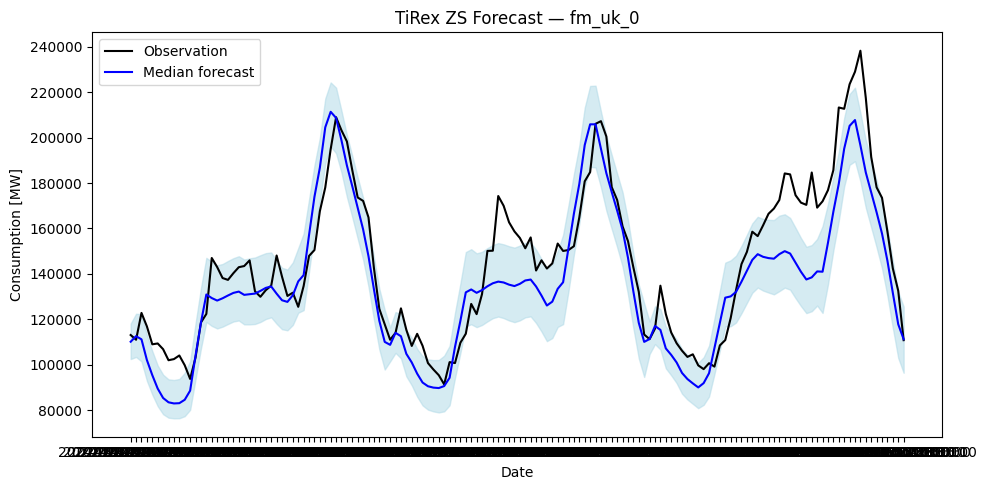

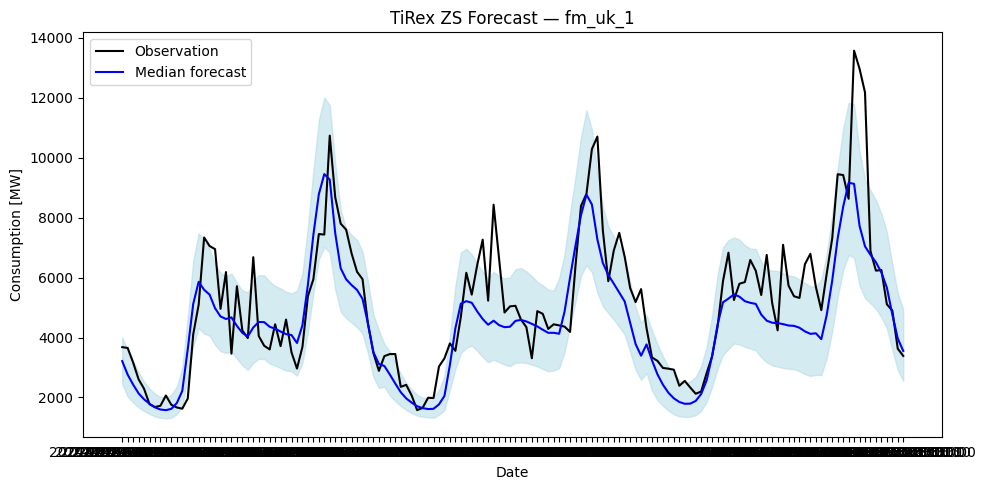

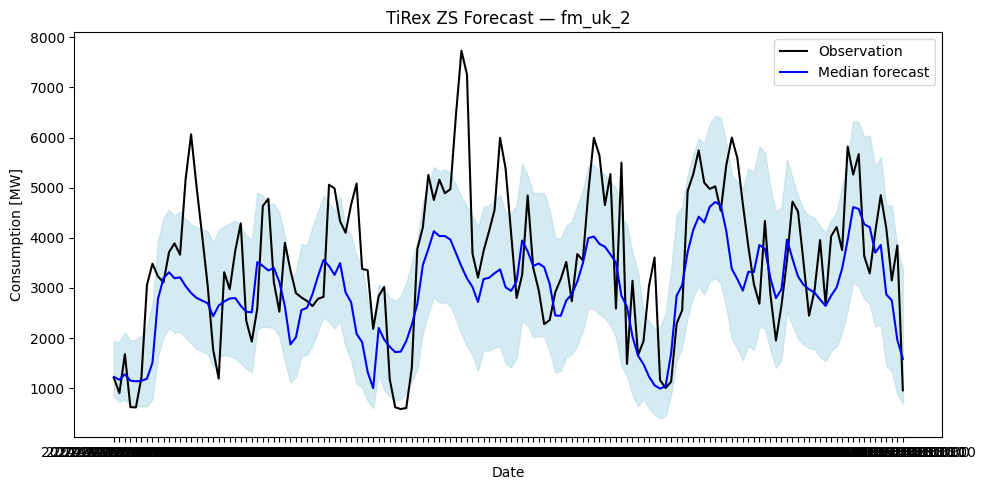

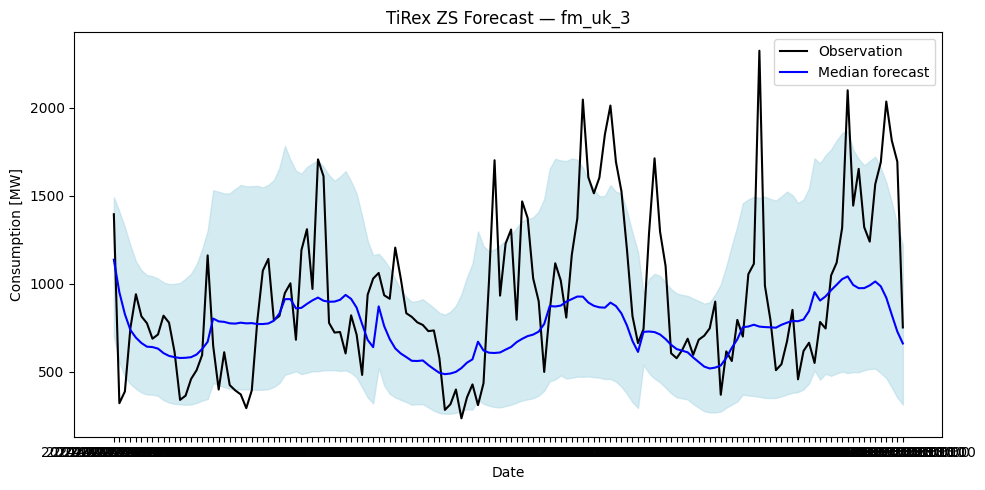

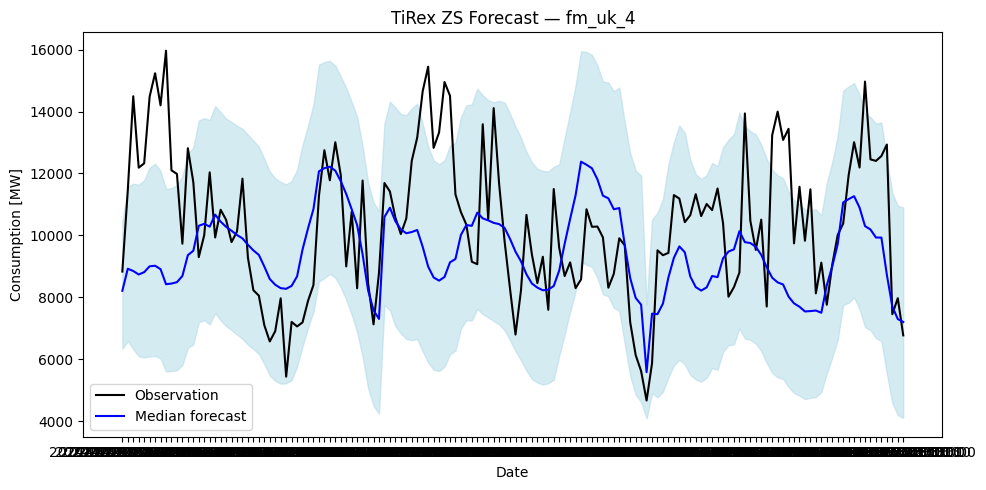

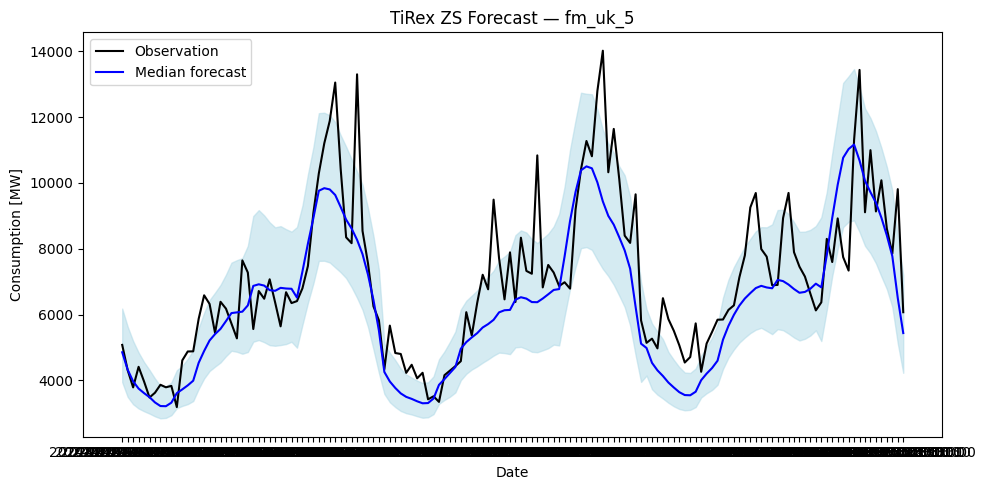

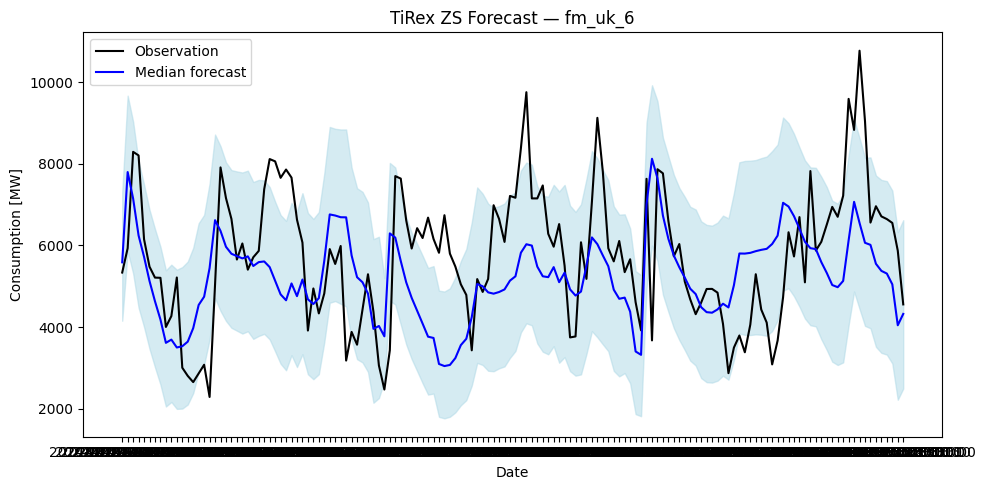

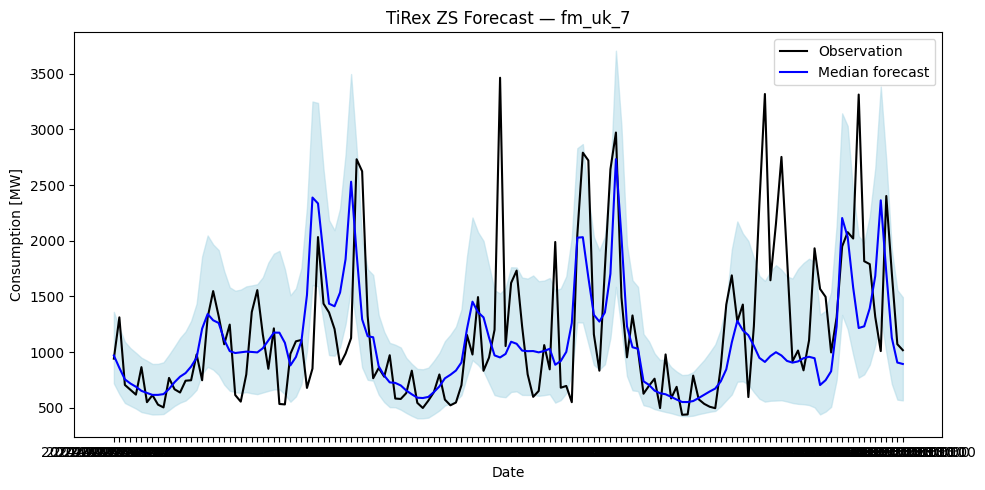

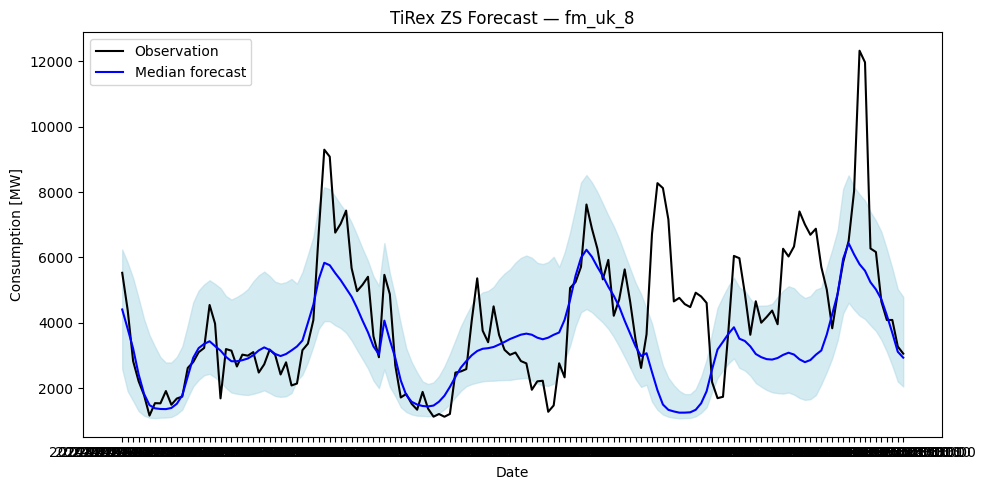

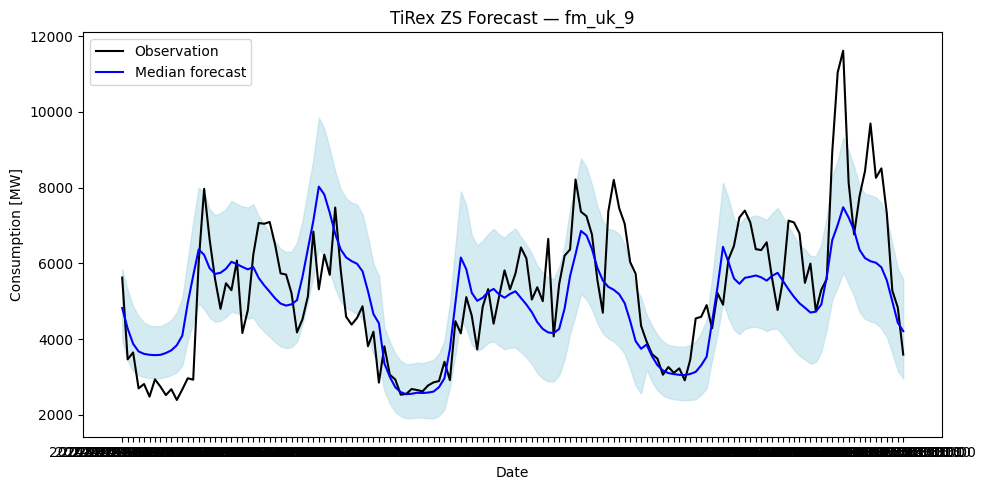

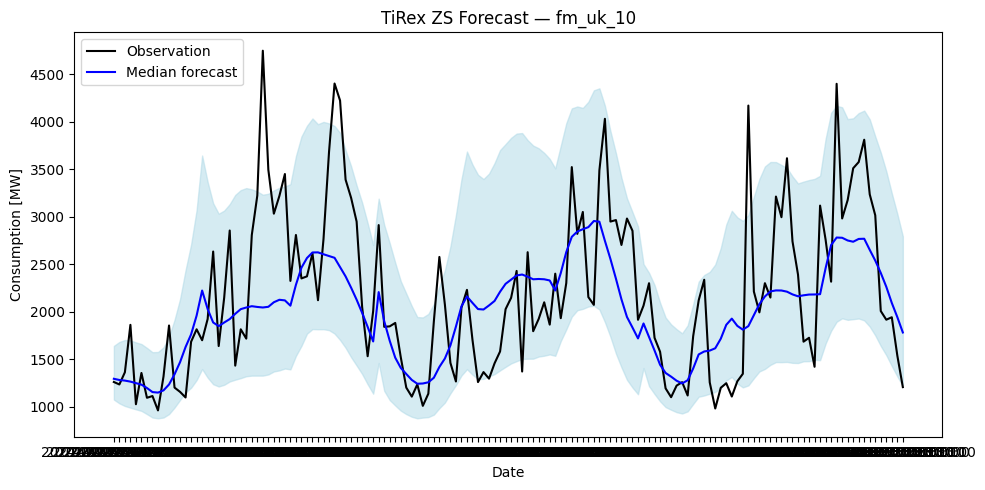

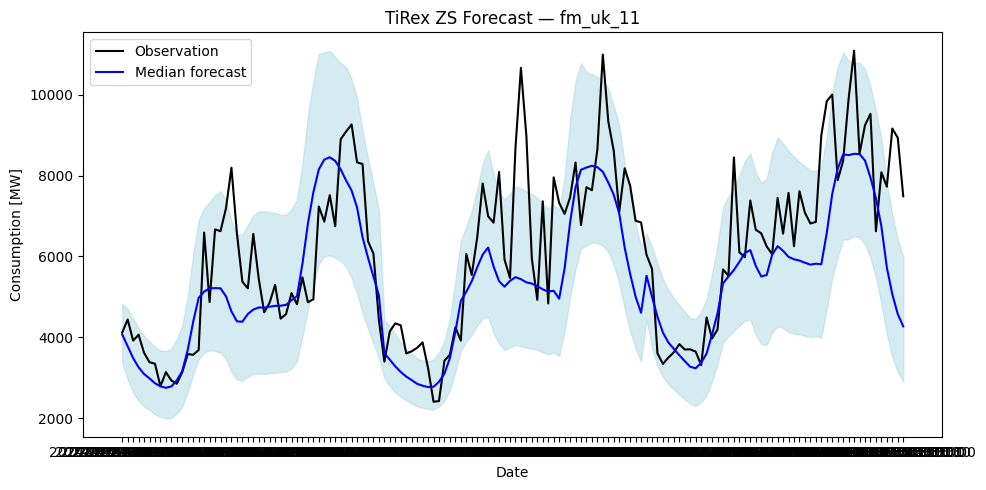

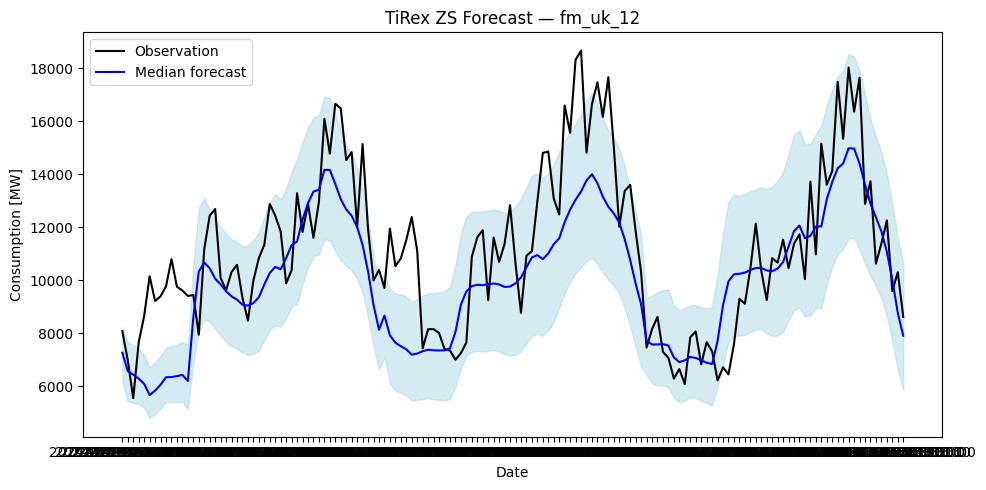

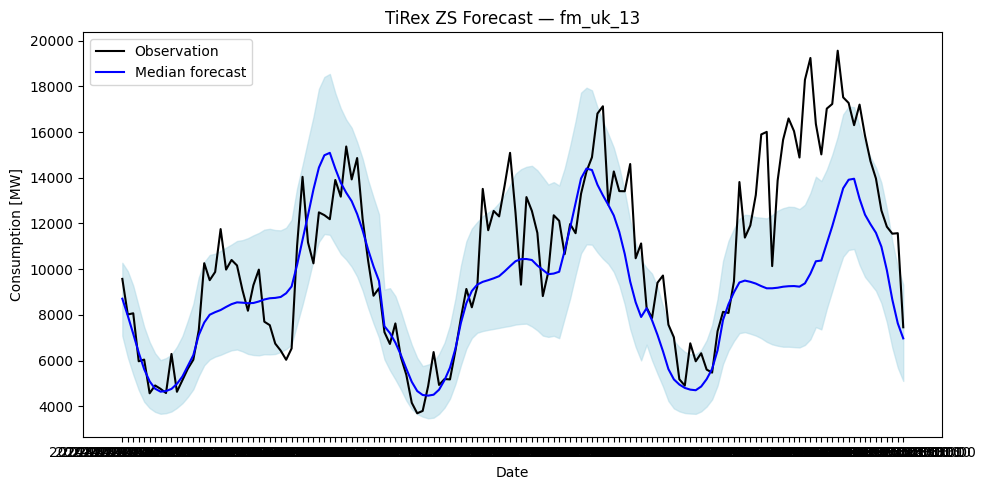

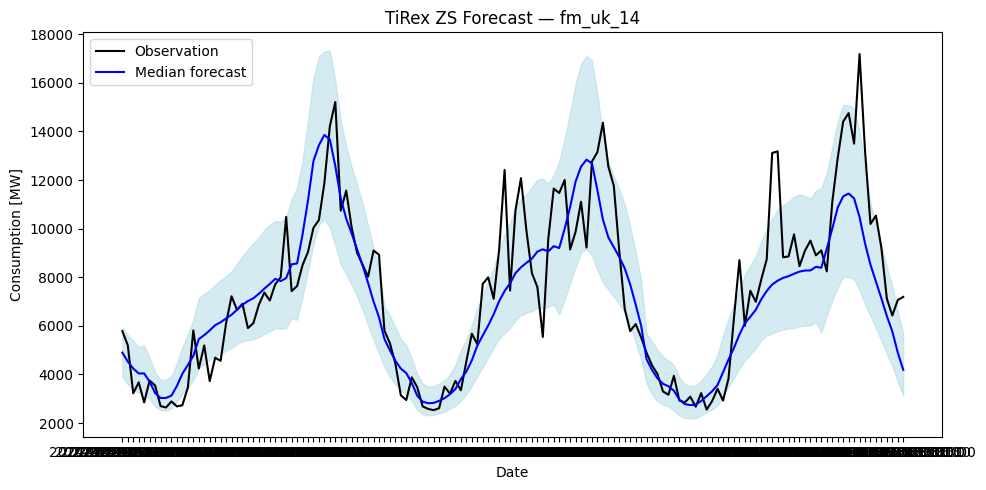

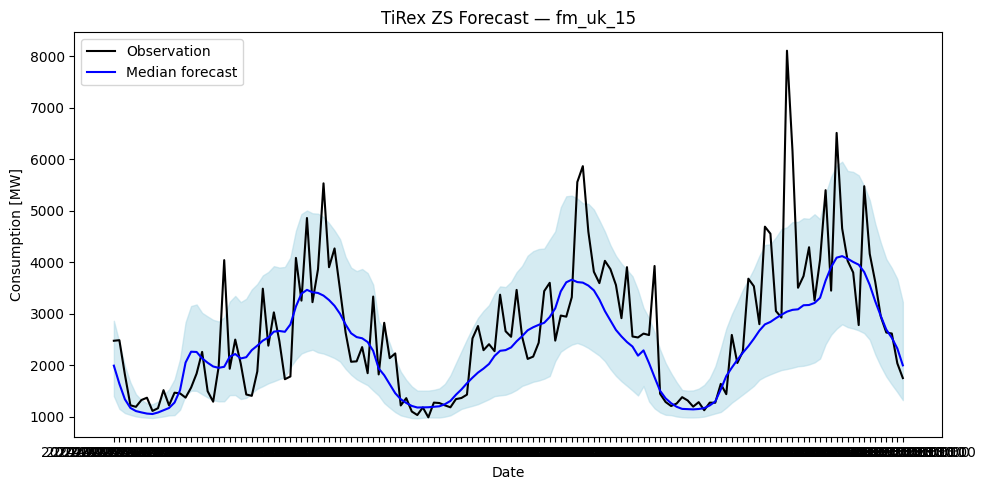

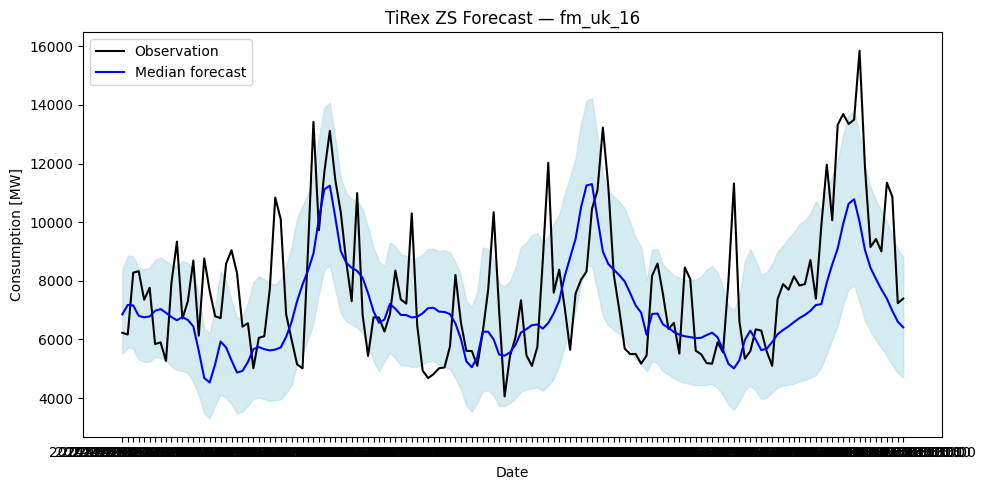

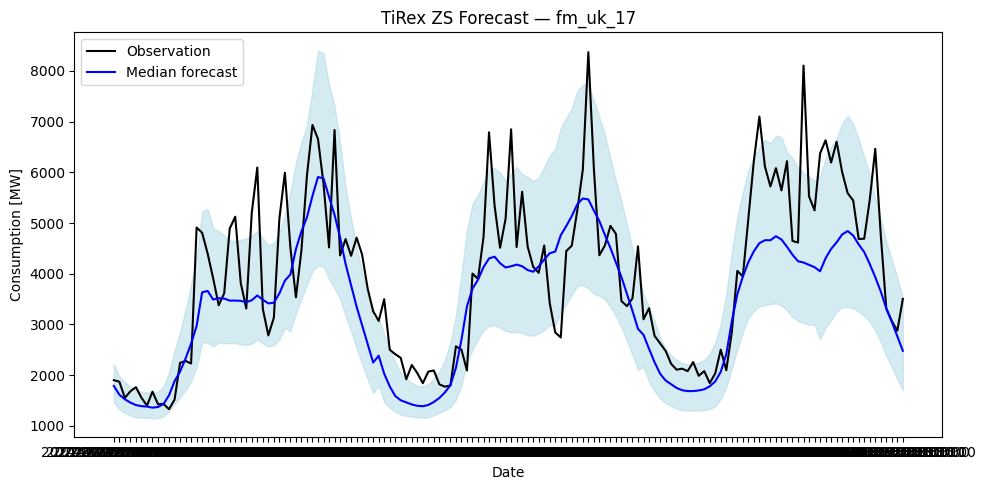

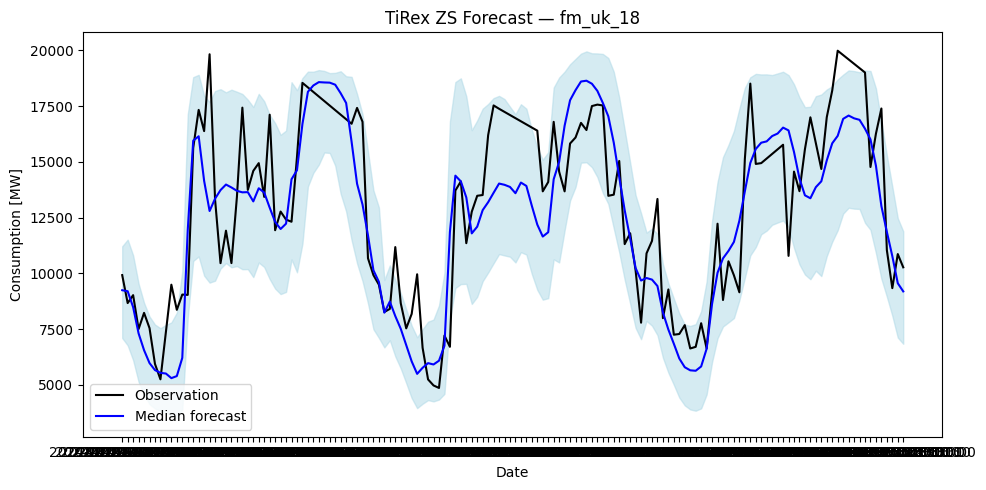

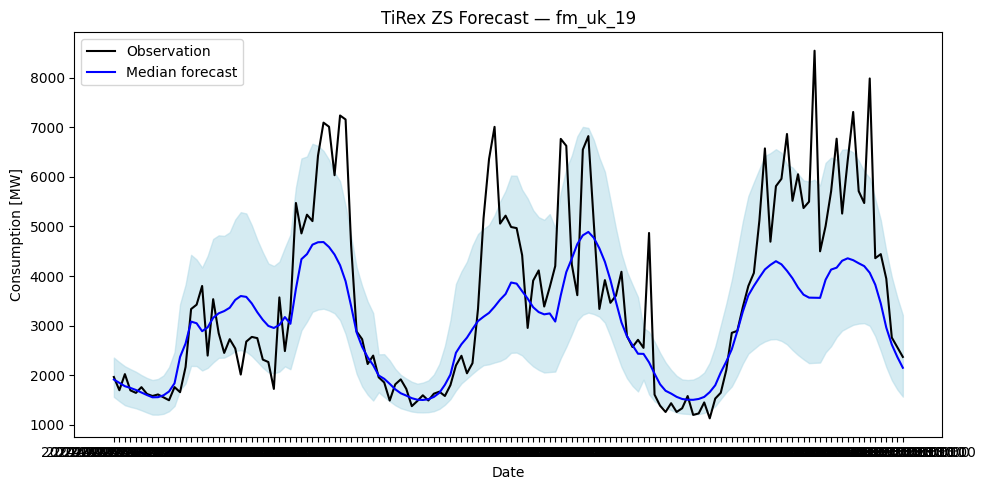

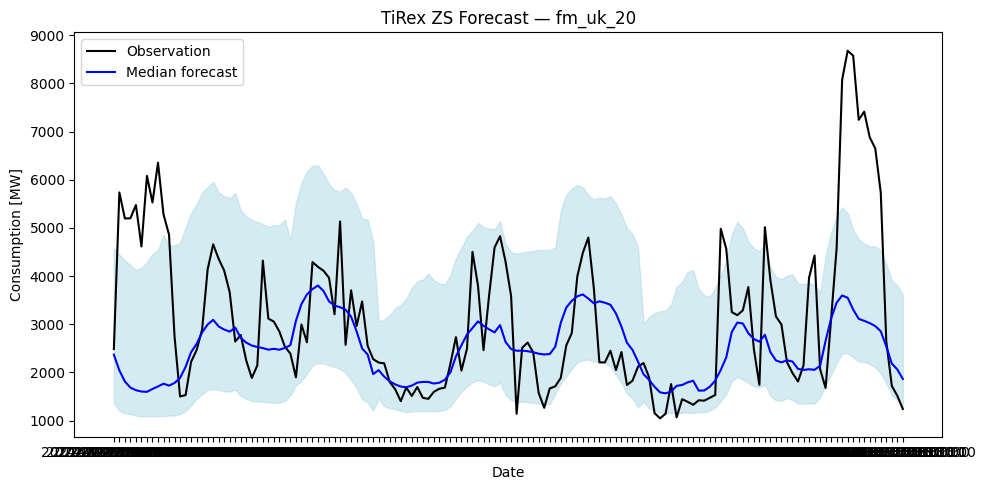

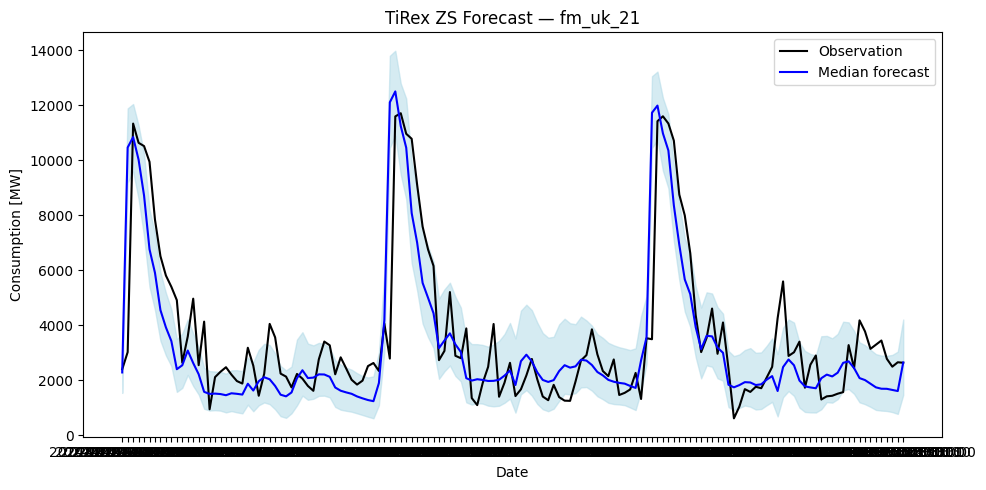

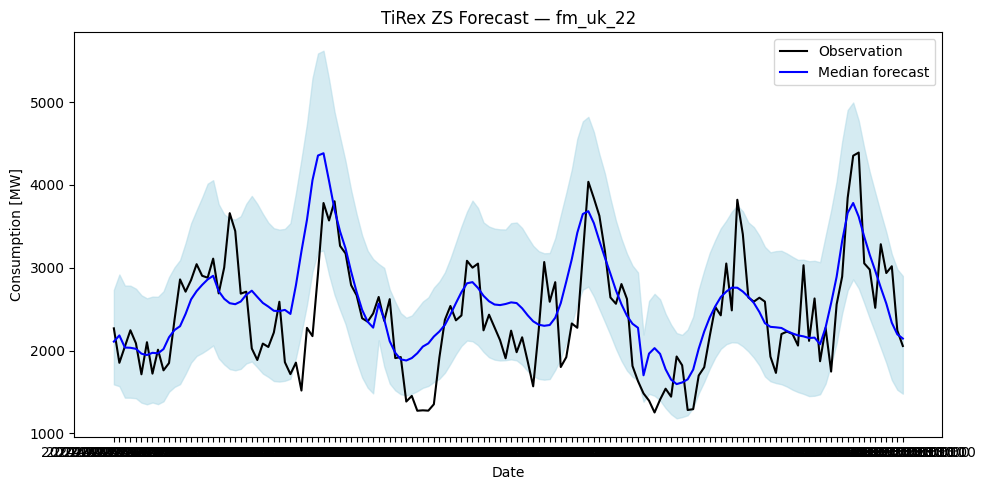

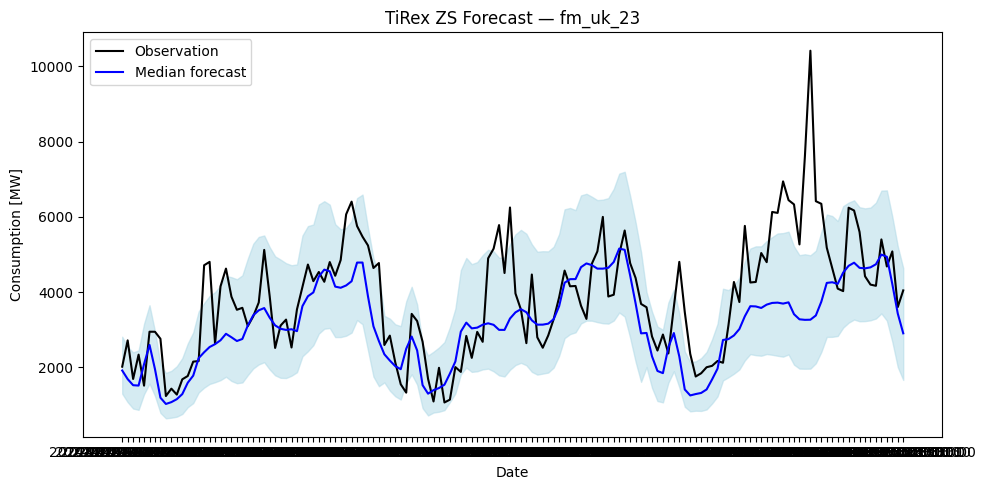

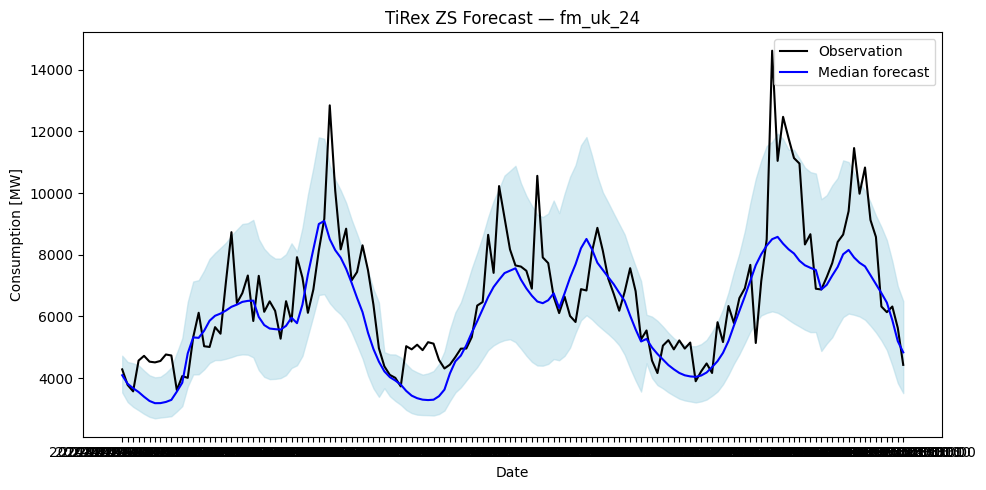

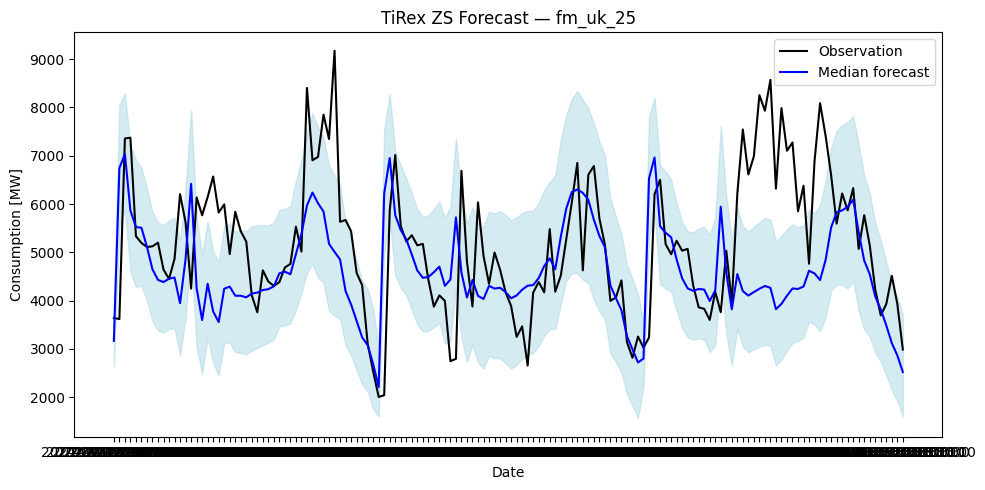

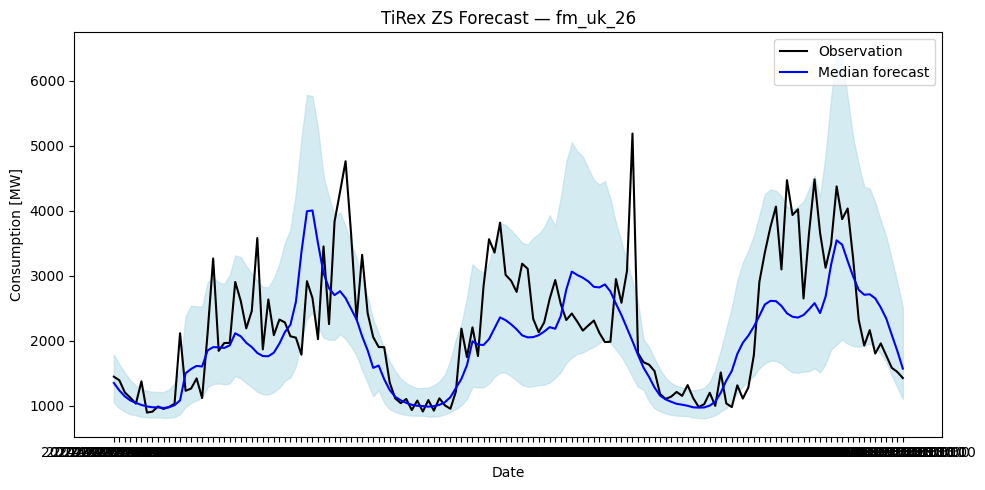

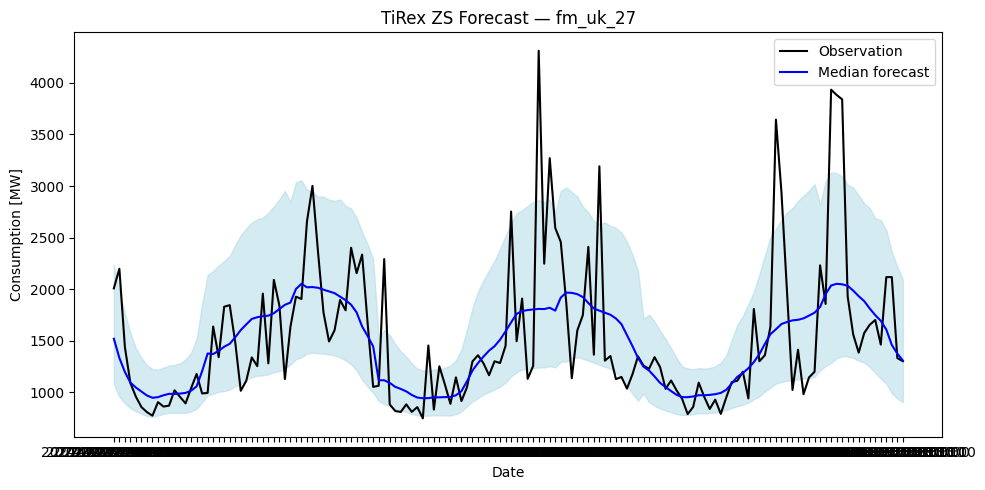

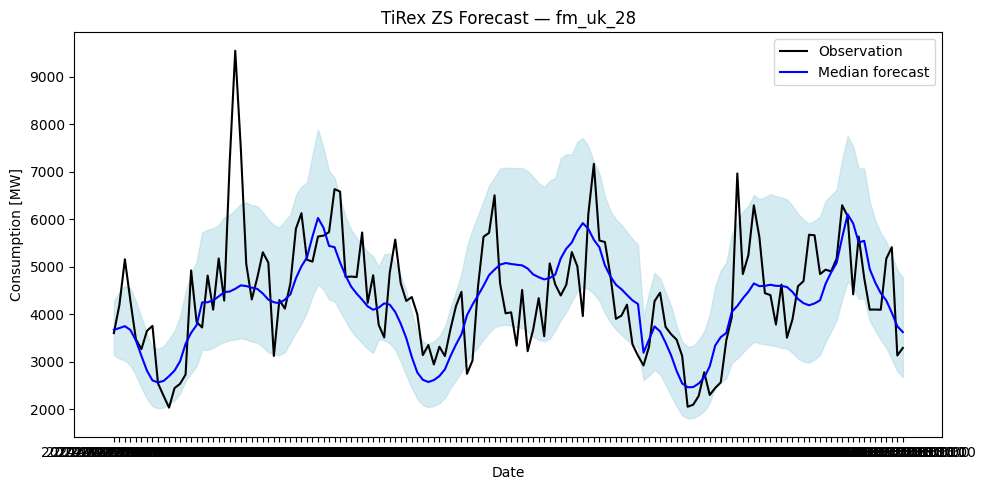

In [ ]:
visualize_existing_results(config_files)